In [1]:
%matplotlib widget
from ipywidgets import *
from astropy.io import fits
import astropy.time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv
import imutils
from scipy import ndimage

# Open the fits cube, lightcurve data and bad pixel map

## Fits cube

In [182]:
cube = fits.open('Data/Corrected_Data/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_SubArray_V0300.fits')
cube.info()

SubArray = cube[1].data
#MetaData = cube[9].data

cube.close()

Filename: Data/Corrected_Data/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_COR_SubArray    1 ImageHDU       148   (200, 200, 149)   float64   
  2  SCI_COR_ImageMetadata    1 BinTableHDU    180   149R x 41C   [26A, 1D, 1D, 8A, 1E, 1E, 8A, 8A, 1E, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1I, 1B, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D]   
  3  PIP_COR_Centroid    1 BinTableHDU     95   149R x 9C   [26A, 1D, 1D, 1I, 1E, 1E, 1E, 1E, 1B]   
  4  SCI_COR_SmearingRow    1 ImageHDU        62   (200, 1, 149)   float64   
  5  SCI_COR_SmearingRowError    1 ImageHDU        62   (200, 1, 149)   float64   


## Lightcurve data

In [183]:
lightcurve = 'Data/visit_PR149000_TG012001/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_Lightcurve-DEFAULT_V0300.fits'
lightcurve_file = fits.open(lightcurve)
lightcurve_data = lightcurve_file[1].data
lightcurve_header = lightcurve_file[1].header
lightcurve_file.close()

time = lightcurve_data['BJD_TIME']
roll_angle = lightcurve_data['ROLL_ANGLE']

## Bad pixel map

In [4]:
pixel_cube = fits.open('Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits')
pixel_cube.info()
BadPixelMap = pixel_cube[1].data
pixel_cube.close()

Filename: Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  REF_APP_BadPixelMap    1 ImageHDU        58   (1024, 1024)   int16   
  2  REF_APP_BadPixelMapLeft    1 ImageHDU        42   (16, 1024)   int16   
  3  REF_APP_BadPixelMapRight    1 ImageHDU        42   (16, 1024)   int16   
  4  REF_APP_BadPixelMapTop    1 ImageHDU        42   (1024, 3)   int16   
  5  REF_APP_PhotPixelMap    1 ImageHDU        35   (1024, 1024)   uint8   
  6  REF_APP_PhotPixelMapLeft    1 ImageHDU        36   (16, 1024)   uint8   
  7  REF_APP_PhotPixelMapRight    1 ImageHDU        36   (16, 1024)   uint8   
  8  REF_APP_PhotPixelMapTop    1 ImageHDU        36   (1024, 3)   uint8   


# Defining mean and median

In [207]:
median = np.median(SubArray[:,:,:], axis=0)
mean = np.mean(SubArray[:,:,:], axis=0)

subtract = np.array(np.broadcast_to(median,np.shape(SubArray)))

cleaned_SubArray = SubArray - subtract

# Make a histogram

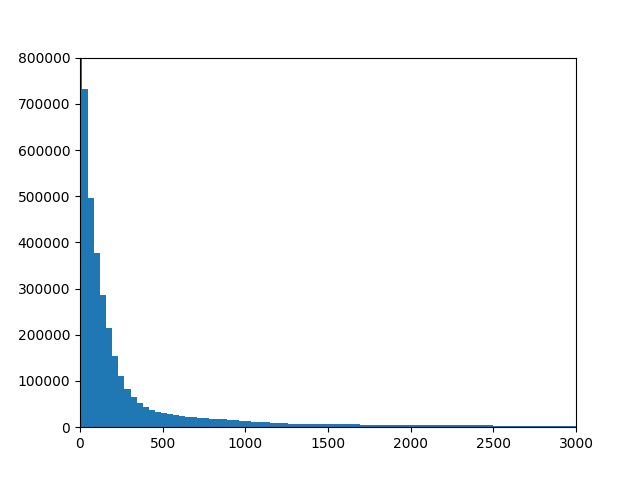

In [6]:
#reshape array from 3d to 2d
flattened_Array = np.ndarray.flatten(SubArray)
#plot a histogram
plt.figure()
plt.hist(flattened_Array, bins=800)
plt.ylim(top=0.8e6)
plt.xlim(left = 0, right=3000)
plt.show()

In [7]:
plt.close()

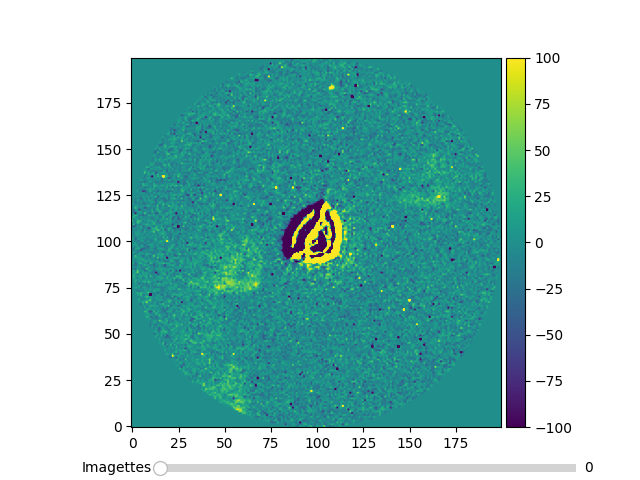

In [214]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(cleaned_SubArray[0,:,:], vmin=-100, vmax=100)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 224, valstep=1)

def update(val):
    array = cube_mask[val,:,:]
    ax.imshow(array, vmin=-100, vmax=100)
    ax.invert_yaxis()
slider.on_changed(update)

plt.show()

In [9]:
plt.close()

# Derotate image

In [192]:
# replace NaN values with 0

def nan_to_0(input_array):
    input_array[np.isnan(input_array)] = 0
    return(input_array)

SubArray_corr = nan_to_0(SubArray)

In [193]:
def roll_angle_correction(data_array, roll_angle_array):
    rotated_array = np.empty(shape=(0,200,200))
    example_shape_array = np.empty(shape=(1,200,200))
    for i in range(len(data_array[:,0,0])):
        rotated_image = np.full_like(example_shape_array,ndimage.rotate(data_array[i,:,:], -roll_angle_array[i], reshape=False))
        rotated_array = np.concatenate((rotated_array, rotated_image))
    
    print(rotated_array.shape)
    return(rotated_array)
        
derotated_cube = roll_angle_correction(SubArray, roll_angle)
print(derotated_cube.shape)
print(SubArray[0,1,:])

(149, 200, 200)
(149, 200, 200)
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 -10.2407834   -7.0618923   -5.5886026  

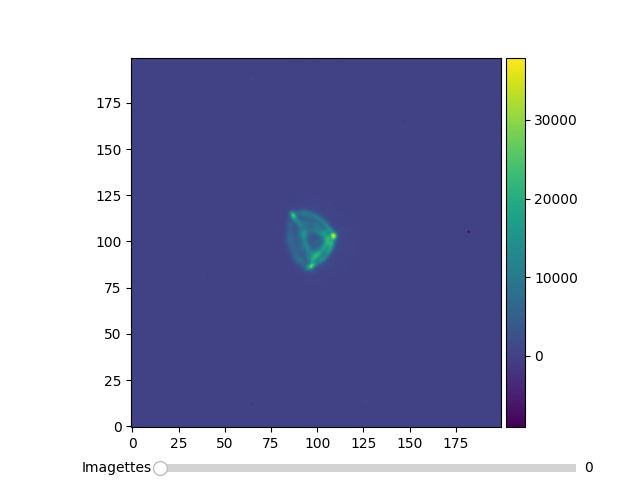

In [194]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(derotated_cube[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 149, valstep=1)

def update(val):
    array = derotated_cube[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)

plt.show()

In [212]:
plt.close()

# Create mask

In [196]:
# calculate new mean/median

mean_new = np.mean(derotated_cube[:,:,:], axis=0)
median_new = np.median(derotated_cube[:,:,:], axis=0)

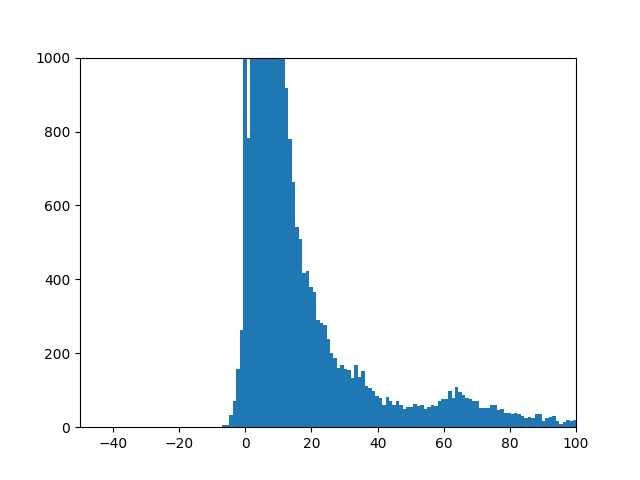

In [197]:
#reshape array from 3d to 2d
flattened_Array = np.ndarray.flatten(median_new)
#plot a histogram
plt.figure()
plt.hist(flattened_Array, bins=1000, range=(-50,1000))
plt.ylim(top=1000)
plt.xlim(left = -50, right=100)
plt.show()

In [198]:
mask = np.zeros(np.shape(median_new))
mask[median_new > 60] = 1

kernel = np.ones((3,3), dtype=np.uint8)
enlarged_mask = cv.dilate(mask, kernel, iterations=2)

In [199]:
def apply_mask(data, mask):
    masked_cube = np.ma.masked_where(mask == 1, data)
    return(masked_cube)

broadcast_mask = np.array(np.broadcast_to(enlarged_mask,np.shape(median_new)))
median_mask = apply_mask(median_new, broadcast_mask)

mask = np.zeros(np.shape(median_mask))
mask[median_mask > 60] = 1

median_broadcast = np.array(np.broadcast_to(mask,np.shape(derotated_cube)))
cube_mask = apply_mask(derotated_cube, median_broadcast)

print(cube_mask[0,100,:])

[-4.562386230408732 -11.10546520637907 -15.471489473446004
 38.25353973626674 64.85709662101159 -17.979080209974956
 -38.74890384167515 7.849383139161045 24.20529673809409 36.52438658772966
 -13.092362886416328 44.260138786773695 16.493811097525512
 -26.41284682700322 -25.143183512408875 -13.625514100767345
 -9.549430746019466 6.304286841933451 8.976585320142265 131.11798283456
 20.956484461617336 -3.56573855475549 -17.95284335660345
 -0.4271122987303803 -4.246680367812531 40.02479893370082
 44.073705737154484 9.944036431608794 30.961022258084448
 114.60479438233811 1.3496801073411107 144.05053863097396
 23.218785189908733 76.13873934393206 63.07533941613344 -3.633894745478239
 -8.714078135611421 25.39604925040644 26.045566227848305 140.9525736081612
 36.987143622726805 -11.102944090411873 -12.803531684747133
 1.1518425860702703 0.4042325860079874 5.689970631861357
 -4.439483610540424 -2.5816071821084803 11.23547583709868
 135.15156116464456 100.95259591683252 76.6894363816588 9.882072

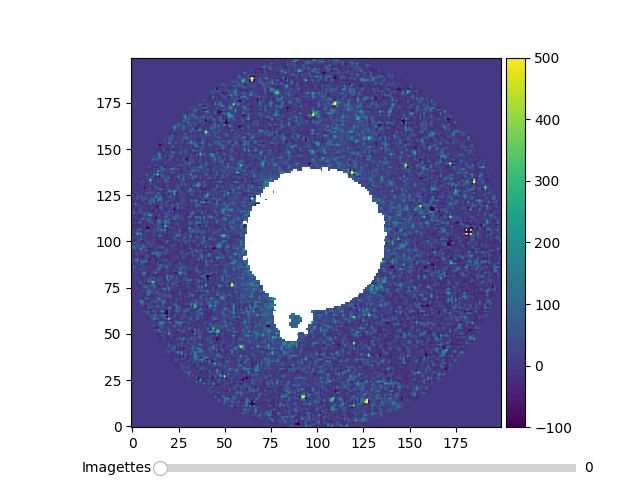

In [203]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(cube_mask[0,:,:], vmin=-100, vmax=500)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 224, valstep=1)

def update(val):
    array = cube_mask[val,:,:]
    ax.imshow(array,vmin=-100, vmax=500)
    ax.invert_yaxis()
slider.on_changed(update)


plt.show()

In [213]:
plt.close()